<a href="https://colab.research.google.com/github/ansonkwokth/TableTennisPrediction/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

In [454]:
import numpy as np
from tqdm import tqdm

class RatingSystem:
    def __init__(self, params=None, learning_rate=0.01, base_param=(0, 1), update_sigma=True, verbose=False):
        """
        Initialize the rating system.

        :param params: Parameters for the players.
        :param learning_rate: Learning rate.
        """
        self.params = {} if params is None else params
        self.learning_rate = learning_rate
        self.base_param = base_param
        self.verbose = verbose
        self.update_sigma = update_sigma



    def get_params(self, player):
        """
        Retrieve the current rating of a player. If the player does not exist, raise an error.

        :param player: The player's name or identifier.
        :return: Current rating of the player.
        """
        return self.params.get(player, self.base_param)



    def _add_sigma(self, sigma1, sigma2):
        return np.sqrt(sigma1**2 + sigma2**2)



    def expected_prob(self, param1, param2):
        """
        Calculate the expected prob. for Player A against Player B.

        :param param1: Parameters of Player 1.
        :param param2: Parameters of Player 2.
        :return: Expected prob for Player 1.
        """

        # Calculate the combined sigma and the difference in mu values
        sigma_tot = self._add_sigma(param1[1], param2[1])
        mu_diff = param1[0] - param2[0]
        z = mu_diff / sigma_tot

        # Calculate the predicted probability using the logistic function
        return 1 / (1 + np.exp(-z))



    def predict_point(self, player1, player2):
        """
        Predict the probability of Player 1 winning against Player 2 in a set.

        :param player1: Name or identifier of Player 1.
        :param player2: Name or identifier of Player 2.
        :return: Probability of Player A winning.
        """
        if self.verbose:
            for player in [player1, player2]:
                if player not in self.params: print(f'Player "{player}" not found. initialize param: {self.base_param}')

        param1 = self.get_params(player1)
        param2 = self.get_params(player2)
        return self.expected_prob(param1, param2)



    def predict_set_config(self, player1, player2):

        p = self.predict_point(player1, player2)
        q = 1 - p
        dt = {}

        # Calculate probabilities for the first 10+ points won by player 1
        for i in range(10):
            prob = comb(10 + i, 10) * p**11 * q**i
            dt[10 + i + 1] = prob  # Store probability for player 1 winning 11, 12, ... points
        # Calculate probability for the special case of winning exactly 22 points
        dt[22] = (1 / (1 - 2 * q * p)) * comb(20, 10) * p**12 * q**10

        return dt



    def predict_set(self, player1, player2):
        return sum(self.predict_set_config(player1, player2).values())



    def predict_game_config(self, player1, player2, n_win_sets=3):
        p = self.predict_set(player1, player2)
        q = 1 - p
        dt = {}

        # Calculate probabilities for winning n_win_sets, n_win_sets+1, ...
        for i in range(n_win_sets):
            prob = comb(n_win_sets - 1 + i, n_win_sets - 1) * p**n_win_sets * q**i
            dt[n_win_sets + i] = prob  # Store probability for winning sets

        return dt


    def predict_game(self, player1, player2):
        return sum(self.predict_game_config(player1, player2).values())




    def add_player(self, player, param=None):
        """
        Add a new player with an optional custom rating.

        :param player: Name or identifier of the player.
        :param rating: Custom initial rating (defaults to base_rating if not provided).
        """
        if player not in self.params:
            self.params[player] = param if param is not None else self.base_param



    def display_params(self, round_digits=2):
        """
        Display the current ratings of all players, rounded to the specified number of digits.

        :param round_digits: Number of decimal places to round the parameters. Default is 2.
        """
        sorted_params = sorted(self.params.items(), key=lambda x: x[1][0], reverse=True)

        for player, param in sorted_params:
            rounded_param = tuple(round(value, round_digits) for value in param)
            print(f"{player}: {rounded_param}")





    def update_params(self, player1, player2, result1):
        """
        Update ratings for two players after a match.

        :param player1: Name or identifier of Player 1.
        :param player2: Name or identifier of Player 2.
        :param result1: Result for Player 1 (points1 / points_tot).
        """
        param1 = self.get_params(player1)
        param2 = self.get_params(player2)  # Fixed to get params for player2 instead of player1

        expected1 = self.expected_prob(param1, param2)
        mu_diff = param1[0] - param2[0]
        sigma_tot = self._add_sigma(param1[1], param2[1])

        # Calculate updates
        mu1_update = (expected1 - result1) / sigma_tot
        mu2_update = - (expected1 - result1) / sigma_tot
        sigma1_update = sigma2_update = 0
        if self.update_sigma:
            sigma1_update = (-mu_diff * param1[1]) / sigma_tot**3 * (expected1 - result1)
            sigma2_update = (-mu_diff * param2[1]) / sigma_tot**3 * (expected1 - result1)

        # Update ratings and assign new tuples
        self.params[player1] = (
            param1[0] - self.learning_rate * mu1_update,
            param1[1] - self.learning_rate * sigma1_update
        )
        self.params[player2] = (
            param2[0] - self.learning_rate * mu2_update,
            param2[1] - self.learning_rate * sigma2_update
        )


    def fit(self, dataset):
        """
        Fit the model to a dataset of matches.

        :param dataset: A list of dictionaries or a DataFrame-like object with columns:
                        - 'player_a': Name or ID of Player A
                        - 'player_b': Name or ID of Player B
                        - 'result_a': Result for Player A (1 for win, 0.5 for draw, 0 for loss)
        """
        for matchi in tqdm(dataset):
            matchi = matchi.T

            player1, player2 = matchi[0]


            for seti in matchi[1:]:
                # seti = [int(si) for si in seti]
                points1, points2 = seti
                if np.isnan(points1) or np.isnan(points2): continue
                points_sum = points1 + points2
                if points_sum == 0: continue

                result1 = points1 / points_sum

                # # Add players to the system if they are not already in
                self.add_player(player1)
                self.add_player(player2)

                # # Update ratings based on the match result
                self.update_params(player1, player2, result1)




    def evaluate(self, dataset):
        verbose_ = self.verbose
        self.verbose = False
        correct = 0
        n_matches = 0

        history = []
        predictions = []
        for matchi in tqdm(dataset):
            matchi = matchi.T
            player1, player2 = matchi[0]

            p = self.predict_game(player1, player2)
            if p == 0.5: continue
            whowillwin = 0 if p > 0.5 else 1

            win1 = sum(matchi[1:, 0]>matchi[1:, 1])
            win2 = sum(matchi[1:, 0]<matchi[1:, 1])
            whowon = 0 if win1 > win2 else 1

            history.append(win1/(win1 + win2))
            predictions.append(p)

            n_matches += 1
            if (whowon == whowillwin): correct += 1
        self.verbose = verbose_

        acc = correct / n_matches
        print(f'\n === Accuracy: {acc} === \n')
        return acc, np.array(history), np.array(predictions)

# Data

In [ ]:
import numpy as np
import pandas as pd
from math import comb
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# GAME = 'TTStar'
# GAME = 'TTCup'
# GAME = 'SetkaCup'
GAME = 'SetkaCupWomen'
# GAME = 'LigaPro'

SPECIAL_NAME = ['Cho Seungmin', 'Wong Chun Ting', 'Lam Siu Hang', 'Xu Yingbin', 'Wang Lichen', 'Cho Ki Jeong']
INFO_COL = ['ID', 'Round', 'Datetime', 'Player', 'Game']

In [ ]:
def find_round_title_idx(text_split: List[str]) -> Tuple[List[int], List[str]]:

    unique_names = ['-', 'WO', '', 'Awrd'] + SPECIAL_NAME
    round_indices = []
    titles = []

    for i, text in enumerate(text_split):
        if isinstance(text, str):
            try:
                int(text)  # Attempt to convert text to an integer
            except ValueError:
                # Only append if text has no '.' and is not in unique_names
                if '.' not in text and text not in unique_names:
                    print(f"Found title: {text}")
                    round_indices.append(i)
                    titles.append(text)

    print()
    return round_indices, titles


In [ ]:
def put_to_dt(text_split: List[str], idx: List[int]) -> Dict[int, List[str]]:
    """
    Extracts segments of text between specified indices and stores them in a dictionary.

    Args:
        text_split (List[str]): List of text items to extract segments from.
        idx (List[int]): List of indices marking the start of each segment.

    Returns:
        Dict[int, List[str]]: Dictionary where each key is an index and each value is a list of text items between indices.
    """
    dt = {}

    for i, index in enumerate(idx):
        if i != len(idx) - 1:
            dt[index] = text_split[index + 1:idx[i + 1]]
        else:
            dt[index] = text_split[index + 1:]

    return dt

In [ ]:
def find_time_idx(text_split: List[str]) -> List[int]:
  """
  Finds indices in a list where the items contain a colon (':'),
  indicating a potential time entry.

  Args:
      text_split (List[str]): List of text items to search.

  Returns:
      List[int]: List of indices where items contain a colon.
  """
  time_indices = []

  for i, text in enumerate(text_split):
      if text and ':' in text:
          time_indices.append(i)

  return time_indices


In [ ]:
def find_players_idx(text_split: List[str]) -> List[int]:
    """
    Finds indices in a list that correspond to player names, excluding empty strings,
    items containing colons, or items that can be converted to integers.

    Args:
        text_split (List[str]): List of text items to search.

    Returns:
        List[int]: List of indices where player names are found.

    Raises:
        Exception: If an odd number of player indices are found.
    """
    player_indices = []

    for i, text in enumerate(text_split):
        if text and ':' not in text:
            try:
                int(text)  # Skip if text can be converted to an integer
            except ValueError:
                player_indices.append(i)

    # Ensure the count of player indices is even
    if len(player_indices) % 2 != 0:
        raise Exception(f'There are {len(player_indices)} players not found, expected an even count.')

    return player_indices


In [ ]:
def change_scores(text_split: List[str], time_idx: List[int], player_idx: List[int]) -> np.ndarray:
    """
    Extracts and reshapes scores from a list of text items, ignoring items at specified indices.

    Args:
        text_split (List[str]): List of text items to process.
        time_idx (List[int]): List of indices corresponding to time entries.
        player_idx (List[int]): List of indices corresponding to player entries.

    Returns:
        np.ndarray: 2D array of extracted scores, reshaped with 2 rows.
    """
    scores = []

    for i, text in enumerate(text_split):
        if text and i not in time_idx and i not in player_idx:
            scores.append(int(text))

    return np.array(scores).reshape(2, -1)

In [ ]:
def create_all_lt(dt_title: Dict[int, List[str]], text_split: List[str], year: int) -> List[List[Any]]:
    """
    Generates a list of game data entries based on provided title sections, split text, and a specified year.

    Args:
        dt_title (Dict[int, List[str]]): Dictionary with indices as keys and lists of text entries as values.
        text_split (List[str]): Original list of text items.
        year (int): Year for timestamp formatting.

    Returns:
        List[List[Any]]: List of game data entries, each containing game ID, title, time, and scores.
    """
    game_id = 0
    all_games = []

    for k, text_section in dt_title.items():
        # Find indices of time markers and split the section into time intervals
        time_indices = find_time_idx(text_section)
        dt_time = put_to_dt(text_section, time_indices)

        for kt, vt in dt_time.items():
            vt_array = np.array(vt)

            # Skip if any special markers are present
            if "WO" in vt_array or "Awrd" in vt_array:
                continue

            # Reshape and transpose scores
            score = vt_array.reshape(-1, 2).T
            timestamp = f"{year}.{text_section[kt]}"

            # Prepare two rows for each game
            row1 = [game_id, text_split[k], timestamp] + list(score[0, :])
            row2 = [game_id, text_split[k], timestamp] + list(score[1, :])

            # Skip games with exactly two score columns
            if score.shape[1] == 2:
                continue

            # Append rows to the list
            all_games.append(row1)
            all_games.append(row2)
            game_id += 1

    return all_games

In [ ]:
def create_df(all_lt: List[List[Any]]) -> pd.DataFrame:
    """
    Converts a list of game data into a DataFrame with appropriately labeled columns.

    Args:
        all_lt (List[List[Any]]): List of game data entries.

    Returns:
        pd.DataFrame: DataFrame with labeled columns, including 'Date' and 'Time' derived from 'Datetime'.
    """

    # Determine the maximum length of rows to create the correct number of columns
    max_length = max(len(row) for row in all_lt)

    # Generate column names for sets based on the difference between max_length and INFO_COL length
    set_column_names = [f'Set{i + 1}' for i in range(max_length - len(INFO_COL))]

    # Create DataFrame with dynamic columns
    df = pd.DataFrame(all_lt, columns=INFO_COL + set_column_names)

    # Reverse the DataFrame for desired ordering
    df = df.iloc[::-1].reset_index(drop=True)

    # Convert 'Datetime' column to separate 'Date' and 'Time' columns
    df['Date'] = pd.to_datetime(df['Datetime'], format="%Y.%d.%m. %H:%M", errors='coerce').dt.date
    df['Time'] = pd.to_datetime(df['Datetime'], format="%Y.%d.%m. %H:%M", errors='coerce').dt.time

    return df[INFO_COL + ['Date', 'Time'] + set_column_names]

In [ ]:
def create_df_from_text(text: str, year: int) -> pd.DataFrame:
    """
    Processes a text input to create a DataFrame with game data for a given year.

    Args:
        text (str): Raw text data containing game information.
        year (int): Year to use in date formatting.

    Returns:
        pd.DataFrame: DataFrame with structured game data.
    """

    # Split text by lines and remove any empty entries
    text_split = [line for line in text.split('\n') if line]

    # Find indices and titles for each round
    round_idx, titles_lt = find_round_title_idx(text_split)
    dt_title = put_to_dt(text_split, round_idx)

    # Create list of all game data entries and convert to DataFrame
    all_lt = create_all_lt(dt_title, text_split, year)
    df = create_df(all_lt)
    df = df.replace({None: np.nan})

    return df

In [ ]:
def read_file(file_path: str) -> str:
    """Reads the entire contents of a file and returns it as a string."""
    with open(file_path, 'r') as file:
        return file.read()

def load_game_data(game: str, years: list) -> dict:
    """Loads game data for the specified game and years into a dictionary."""
    text_data = {}
    for year in years:
        file_path = f'./{game}{year}.txt'
        text_data[year] = read_file(file_path)

    return text_data



In [ ]:
def create_game_dfs(game: str, years: list, text_data: dict) -> pd.DataFrame:
    """Creates DataFrames for each year based on the game type and concatenates them into a single DataFrame."""
    dfs = []
    for year in years:
        df = create_df_from_text(text_data[year], year)
        dfs.append(df)
    df_tot = pd.concat(dfs, ignore_index=True)
    df_tot.sort_values(by=['Date', 'Time'], inplace=True)
    df_tot.reset_index(drop=True, inplace=True)
    return df_tot

In [ ]:
GAME = 'SetkaCupWomen'


if GAME == 'TTStar':
    # years = [2020, 2021, 2022, 2023, 2024]
    years = [2020, 2021, 2022, 2023]
elif GAME == 'TTCup':
    years = [2020, 2021, 2022, 2023, 2024]
elif GAME == 'SetkaCup':
    years = [2020, 2021, 2022, 2023, 2024]
elif GAME == 'SetkaCupWomen':
    years = [2020, 2021, 2022, 2023, 2024]
    # years = [2020, 2021, 2022, 2023]
elif GAME == 'LigaPro':
    years = [2022, 2023, 2024]
else:
    raise ValueError("Invalid game selected.")


text_data_game = load_game_data(GAME, years)
text_data = {
    year: text_data_game[year] for year in years
}
df = create_game_dfs(GAME, years, text_data)

Found title: OTHERS - WOMEN
Found title: : 
Found title: Setka Cup (World)

Found title: OTHERS - WOMEN
Found title: : 
Found title: Setka Cup (World)

Found title: OTHERS - WOMEN
Found title: : 
Found title: Setka Cup (World)

Found title: OTHERS - WOMEN
Found title: : 
Found title: Setka Cup (World)

Found title: OTHERS - WOMEN
Found title: : 
Found title: Setka Cup (World)



In [ ]:
# Generate ID indices for each pair of rows in the DataFrame
idx_lt = [i for i in range(len(df) // 2) for _ in range(2)]
df['ID'] = idx_lt  # Assign to the 'ID' column

# Reset the DataFrame index to ensure it's sequential
df.reset_index(drop=True, inplace=True)

# Get unique players and store them in player_lt
player_lt = df['Player'].unique()



In [ ]:
year_val = years[-2]
year_test = years[-1]

df_train = df.loc[pd.DatetimeIndex(df['Date']).year < year_val]
df_val = df.loc[pd.DatetimeIndex(df['Date']).year == year_val]
df_test = df.loc[pd.DatetimeIndex(df['Date']).year == year_test]

In [ ]:
def format_to_array(df: pd.DataFrame) -> np.ndarray:

    info_col = ['ID', 'Round', 'Datetime', 'Game', 'Date', 'Time']
    col = [item for item in df.columns if item not in info_col]

    df[[c for c in col if "Set" in c]] = df[[c for c in col if "Set" in c]].astype(float)
    X = df[col].values.reshape(-1, 2, len(col))
    return X

In [410]:
X_train = format_to_array(df_train)
X_val = format_to_array(df_val)
X_test = format_to_array(df_test)

# Train and Evaluate

In [455]:
model = RatingSystem(learning_rate=0.1)
# model = RatingSystem(learning_rate=0.01, base_param=(0, 0.1))
# model = RatingSystem(learning_rate=0.01, base_param=(0, 0.1), update_sigma=False)
# model = RatingSystem(learning_rate=0.1, base_param=(0, 0.1), update_sigma=False)
model.fit(X_train)


100%|██████████| 26120/26120 [00:01<00:00, 17060.81it/s]


In [456]:
model.evaluate(X_train);
model.evaluate(X_val);
model.evaluate(X_test);

100%|██████████| 26120/26120 [00:01<00:00, 22560.29it/s]



 === Accuracy: 0.6153905053598775 === 



100%|██████████| 6490/6490 [00:00<00:00, 23856.29it/s]



 === Accuracy: 0.5603715170278638 === 



100%|██████████| 1969/1969 [00:00<00:00, 25622.24it/s]


 === Accuracy: 0.5539606592238171 === 



In [457]:
acc, history, predictions = model.evaluate(X_test)

100%|██████████| 1969/1969 [00:00<00:00, 24322.86it/s]


 === Accuracy: 0.5539606592238171 === 



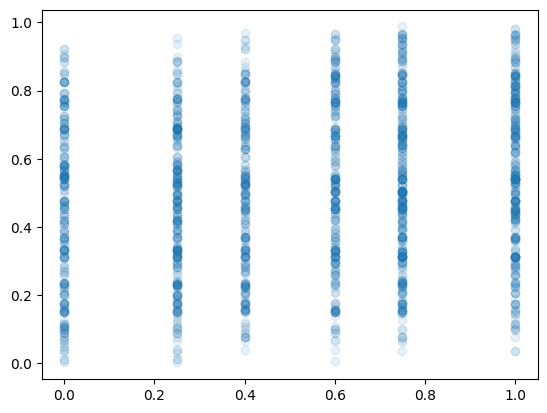

In [458]:
plt.scatter(history, predictions, alpha=0.1)

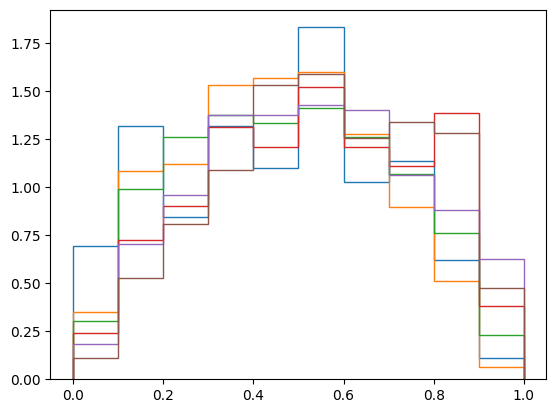

In [476]:
bins_=10
plt.hist(predictions[history == 0], range=[0, 1], bins=bins_, histtype='step', density=True);
plt.hist(predictions[history == 0.25], range=[0, 1], bins=bins_, histtype='step', density=True);
plt.hist(predictions[history == 0.4], range=[0, 1], bins=bins_, histtype='step', density=True);
plt.hist(predictions[history == 0.6], range=[0, 1], bins=bins_, histtype='step', density=True);
plt.hist(predictions[history == 0.75], range=[0, 1], bins=bins_, histtype='step', density=True);
plt.hist(predictions[history == 1], range=[0, 1], bins=bins_, histtype='step', density=True);

In [466]:
np.unique(history)

array([0.  , 0.25, 0.4 , 0.6 , 0.75, 1.  ])

In [470]:
2/5

0.4